# Aula 16 - redução de dimensionalidade

Na aula de hoje, vamos explorar os seguintes tópicos em Python:

- 1) PCA
- 2) PCA na Pipeline
- 3) A matemática do PCA


In [1]:
import numpy  as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

---

## 1) PCA



PCA (principal component analysis) é uma técnica **não supervisionada** que determina **as direções de máxima variância** no espaço de features, de modo que **as direções são ortogonais entre si**.

Ou seja,

> A primeira componente principal é a direção que maximiza a variáncia dos dados projetados em sua direção; A segunda componente principal é uma direção ortogonal à primeira que também maximiza a variância nesta direção, e assim sucessivamente.

<img src=https://austingwalters.com/wp-content/uploads/2014/11/gaussDist-labeled.png width=400>

É importante lembrar que:

- Se o espaço original tem $n$ features, é possível construir $n$ componentes principais;<br><br>
- Cada componente principal é uma **combinação linear das features originais**;<br><br>
- As componentes principais são ortogonais entre si;<br><br>
- As componentes principais são linearmente descorrelacionadas;<br>

É muito comum que PCA seja utilizada como uma técnica de **redução de dimensionalidade**, isto porque, **no espaço transformado de componentes principais**, é comum que grande parte da variância completa dos dados esteja contida nas $L$ primeiras componentes principais ($L < n$).

Sendo assim, ao invés de utilizar o espaço de features completo (de dimensão $n$) para a construção de modelos, podemos utilizar apenas $L$ dimensões **do espaço de features de componentes principais**, reduzindo, assim, a dimensionalidade do espaço de features efetivo em que os estimadores irão trabalhar.

Os objetivos desta redução podem ser:

- Evitar a maldição da dimensionalidade;
- Treinar modelos mais rápido (de maneira mais eficiente), afinal, há menos dados;
- Fornecer dados sem qualquer colinearidade (há estimadores que assumem não-colinearidade!)

### 1.1) O que é cada PC?

Como dissemos acima, cada componente principal é uma **combinação linear das features originais**.

Nesse sentido, podemos enxergar o PCA como um método que constrói um novo espaço de features, de mesma dimensão que o espaço original:

<img src=https://miro.medium.com/max/1200/1*V3JWBvxB92Uo116Bpxa3Tw.png width=700>

O ponto é que o espaço de features construído pelo PCA é muito particular: as novas features são ortogonais entre si, e tais que maximizam a variância dos dados em cada sub-espaço de projeção, como dissemos acima.

Assim, na prática, seja um espaço de input $\mathcal{X}$ de $n$ dimensões, tal que cada vetor de features $\vec{x} \in \mathcal{X}$ é dado por:

$ \vec{x} = \left ( x_1, x_2, x_3, \cdots , x_n \right) $

Após a aplicação do PCA, estaremos no espaço de componentes principais, tal que um vetor de features neste espaço, $\vec{x}_{PC}$, será dado por:

$ \vec{x}_{PC} = \left ( PC_1, PC_2, PC_3, \cdots , PC_n \right) $

Onde cada componente principal é uma combinação linear das features originais, isto é, 

$ PC_i = \sum_{k=1}^n \alpha_{i, k} x_k = \alpha_{i, 1} x_1 +  \alpha_{i, 2} x_2 + \cdots +  \alpha_{i, n} x_n$

Note que cada componente principal $i$ tem $n$ coeficientes diferentes $\alpha_{i, k}$, que acompanham cada uma das features $k$ do espaço original.

Para entender melhor, vamos tomar um dataset bem simples!

In [2]:
df = pd.read_csv('../datasets/iris.csv')

df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [3]:
X = df.drop('species', axis=1)
y = df['species']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

No caso do dataset iris, temos 4 features, de modo que o espaço original tem 4 dimensões, e um vetor de features é:

$ \vec{x} = (x_1, x_2, x_3, x_4)$.

Sendo que:

- $x_1$ : 'sepal_length', 
- $x_2$ : 'sepal_width', 
- $x_3$ : 'petal_length', 
- $x_4$ : 'petal_width'.

Assim, esperamos que após o PCA, o espaço de componentes principais também tenha 4 dimensões, isto é, 

$ \vec{x}_{PC} = \left ( PC_1, PC_2, PC_3, PC_4 \right) $

E as componentes principais serão: 

$ PC_1 = \alpha_{1, 1} x_1 + \alpha_{1, 2} x_2 + \alpha_{1, 3} x_3 + \alpha_{1, 4} x_4$

$ PC_2 = \alpha_{2, 1} x_1 + \alpha_{2, 2} x_2 + \alpha_{2, 3} x_3 + \alpha_{2, 4} x_4$

$ PC_3 = \alpha_{3, 1} x_1 + \alpha_{3, 2} x_2 + \alpha_{3, 3} x_3 + \alpha_{3, 4} x_4$

$ PC_4 = \alpha_{4, 1} x_1 + \alpha_{4, 2} x_2 + \alpha_{4, 3} x_3 + \alpha_{4, 4} x_4$

Vamos agora aplicar o PCA para calcular as componentes principais!

Mas antes, um ponto muito importante: **devemos escalar as features originais com o StandardScaler antes de aplicarmos o PCA**!

Isso porque o método matemático recebe dados com média 0 e desvio padrão 1!

In [4]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler().fit(X_train)

X_train_ss = std.transform(X_train)
X_test_ss = std.transform(X_test)

Agora sim!

In [5]:
from sklearn.decomposition import PCA

pca = PCA(random_state=42).fit(X_train_ss)

Com o PCA fitado, temos alguns atributos importantes!

In [13]:
pca.n_features_in_

4

O atributo `components_` dá exatamente os coeficientes $\alpha_{i, k}$ que determinan as combinações lineares de cada componente principal!

In [11]:
pca.components_

array([[ 0.52679335, -0.25307206,  0.58186918,  0.56557189],
       [ 0.34813945,  0.93470791,  0.02689438,  0.06630793],
       [-0.72745724,  0.22196252,  0.1386138 ,  0.6342908 ],
       [ 0.26850263, -0.11405393, -0.80093144,  0.52288323]])

Ou seja,

$PC_1 = 0.527x_1 -0.253x_2 + 0.582x_3 + 0.566x_4$

$PC_2 = 0.348x_1 + 0.935x_2 + 0.027x_3 + 0.066x_4$

$PC_3 = -0.727x_1 + 0.222x_2 + 0.139x_3 + 0.634x_4$

$PC_4 = 0.269x_1 -0.114x_2 -0.801x_3 + 0.523x_4$

Lembrando que:

- $x_1$ : 'sepal_length', 
- $x_2$ : 'sepal_width', 
- $x_3$ : 'petal_length', 
- $x_4$ : 'petal_width'.

Há alguns outros atributos muito importantes:

In [15]:
pca.explained_variance_ratio_

array([0.72677234, 0.23066667, 0.03781901, 0.00474197])

In [16]:
pca.explained_variance_ratio_.cumsum()

array([0.72677234, 0.95743901, 0.99525803, 1.        ])

Podemos plotar os resultados acima:

<BarContainer object of 4 artists>

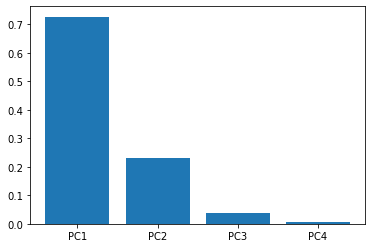

In [23]:
labels = [f'PC{i+1}' for i in range(pca.n_components_)]

plt.bar(labels, pca.explained_variance_ratio_)

Dos resultados, é fácil ver que com apenas 2 componentes principais, capturamos 95% da variância dos dados!

Assim, caso queiramos reduzir o número de dimensões de $n=4$ para $L=2$, temos a garantia de que grande parte da variabilidade estará contida nas duas componentes principais que usaremos para modelagem!

> Veja que a escolha de $L < n$ componentes principais pode ser visto como um procedimento de **feature selection**, mas feito **no espaço de componentes principais!**
> Como não são as features originais que são selecionadas, é comum nos referirmos a este procedimento como **redução de dimensionalidade** (e a dimensionalidade que é reduzida é do espaço de componentes principais!)

De fato, note que **todas as 4 features originais** estão presentes em cada uma das PCs, como termos da combinação linear que define cada PC. E, naturalmente, todas as 4 estão presentes nas $L$ primeiras.

Caso queiramos construir modelos no espaço de componentes principais, é importante que incorporemos o PCA em nossa pipeline! 

Vamos ver na prática!

____________

## 2) PCA na Pipeline

In [8]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [9]:
def metricas_classificacao(estimator, X_train, X_test, y_train, y_test):
    
    # ============================================

    print("\nMétricas de avaliação de treino:")

    y_pred_train = estimator.predict(X_train)

    print(confusion_matrix(y_train, y_pred_train))

    ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
    plt.show()

    print(classification_report(y_train, y_pred_train))

    # ============================================

    print("\nMétricas de avaliação de teste:")

    y_pred_test = estimator.predict(X_test)

    print(confusion_matrix(y_test, y_pred_test))

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
    plt.show()

    print(classification_report(y_test, y_pred_test))

___________

Vamos analisar um outro dataset?

Vamos treinar modelos!

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [ ]:
pipe_no_pca = Pipeline([('lr')])

____________

## 3) A matemática do PCA

(Adaptado do notebook do Walisson!)

__________

Considere a matriz de features $X_{N \times n}$

> $N$ linhas (observações), cada uma caracterizada por $n$ features no espaço original.

Cada observação $i$ é caracterizada pelo vetor de features $\vec{x}_i = (x_{i1}, x_{i2}, \cdots, x_{in}$), que são as linhas da matriz de features:

$$
  X = \left [ \begin{array}{ccccc}
x_{11} & x_{12} & x_{13} & \cdots & x_{1n}\\ 
x_{21} & x_{22} & x_{23} & \cdots & x_{2n}\\ 
\vdots & \vdots & \vdots & \cdots & \vdots  \\
x_{N1} & x_{N2} & x_{N3} & \cdots & x_{Nn}\\ 
   \end{array} \right ] 
$$

### Passo 1 - standardização

Para dados em que as features originais $x_j$ estão em escalas diferentes, é necessário escalar os dados para que eles tenham média 0 e desvio padrão 1 (ou seja, usamos o `StandardScaler`). 

Isso porque os componentes são influenciados pela escala das variáveis, justamente porque as matrizes de covariâncias, $\Sigma$ ou $\hat{\Sigma} = S$, são sensíveis à escala de um par de variáveis. 

Considere:

- $\bar{x}_j$ a média da variável $x_j$; 
- $s(x_j)$ o desvio padrão de $x_j$; 

Sendo $i = 1, 2,3,4,\cdots, N$ e $j = 1, 2,3,4,\cdots, n$.

Com isso, a padronização pode ser realizada por meio da equação abaixo: 

- Média 0 e desvio padrão 1: 

$$ \tilde{x}_{ij}= \frac{x_{ij}-\bar{x_j}}{s(X_j)} $$ 

<br>

### Passo 2 - cálculo da matriz de covariância

Calcular a matriz de **covariância**/**correlação**, que são dadas por:

$$
  S = \left [ \begin{array}{ccccc}
\hat{Var}(x_1) & \hat{Cov}(x_1x_2) & \hat{Cov}(x_1x_3) & \cdots & \hat{Cov}(x_1x_n)\\ 
\hat{Cov}(x_2x_1) &\hat{Var}(x_2)& \hat{Cov}(x_2x_3) & \cdots & \hat{Cov}(x_2x_n)\\ 
\vdots & \vdots & \vdots & \cdots & \vdots  \\
\hat{Cov}(x_nx_1) & \hat{Cov}(x_nx_2)  & \hat{Cov}(x_nx_3)  & \cdots & \hat{Var}(x_n)\\ 
   \end{array} \right ] 
$$

<br>
<br>

$$
  R = \left [ \begin{array}{ccccc}
1 & r(x_1x_2) & r(x_1x_3) & \cdots & r(x_1x_n)\\ 
r(x_2x_1) & 1 & r(x_2x_3) & \cdots & r(x_2x_n)\\ 
\vdots & \vdots & \vdots & \cdots & \vdots  \\
r(x_nx_1) & r(x_nx_2)  & r(x_nx_3)  & \cdots & 1\\ 
   \end{array} \right ] 
$$

Em que:

$$
 \begin{array}{ccc}
\hat{Var}(x_j) = \frac{\sum_{i=1}^{N}(x_{ij}-\bar{x}_j)}{N-1}, & 
\hat{Cov}(x_{j1},x_{j2}) = \frac{\sum_{i=1}^N(x_{ij1}-\bar{x_{j1}})(x_{ij2}-\bar{x_{j2}})}{N-1}, &
r(x_{j1},x_{j2}) = \frac{\hat{Cov}(x_{j1},x_{j2})}{S_{xj1}S_{xj2}}
   \end{array} 
$$

<br>

### Passo 3 - determinação de autovalores e autovetores

As componentes principais são determinadas através da equação característica (equação de autovalores) da matriz S ou R:

$$det[R - \lambda I]= 0 $$

Em que $I$ é a matriz identidade de dimensão $n \times n $. 

Se R ou S tem posto completo igual a $n$, então $det[R - \lambda I]= 0$, que pode ser reescrito como $\mid R - \lambda I \mid = 0$, terá $n$ soluções. Lembrando que ter posto completo significa que nenhuma coluna é combinação linear de outra.

Considere que $\lambda_1,\lambda_2,\lambda_3, \cdots, \lambda_n$ sejam as raízes da equação característica de R ou S, então temos que  $\lambda_1 > \lambda_2 > \lambda_3 > \cdots, \lambda_n$. 

Chamamos $\lambda_i$ de **autovalores**. 

Além disso, para cada autovalor há um **autovetor** $\tilde{a}_i$ associado, $
  \tilde{a}_i = \left [ \begin{array}{c}
a_{i1}\\ 
a_{i2}\\ 
\vdots \\
a_{ip} \\ 
   \end{array} \right ] 
$

O cálculo do autovetor $\tilde{a}_i$, pode ser realizado considerando a seguinte propriedade:

$$ R\tilde{a}_i =  \lambda_i \tilde{a}_i $$

O autovetor deve ser normalizado, isso é,

$$ a_i = \frac{\tilde{a}_i }{\mid \tilde{a}_i  \mid}$$

Desta maneira, as componentes do vetor são tais que sua norma L2 é igual a 1.

<br>

### Passo 4 - cálculo das componentes principais

O cálculo da i-ésima componente principal é dado por:

$$PC_i = a_{i1}x_1 + a_{i2}x_2 + a_{i3}x_3 + \cdots + a_{in}x_n $$

em que $a_{i1}$ são as componetes do autovetor $a_i$ associado ao autovalor $\lambda_i$.

__________

Operacionalmente, o PCA se apoia em um procedimento matemático denominado **Singular Value Decomposition (SVD)**, que é uma forma de decompor qualquer matriz não quadrada $M_{m\times n}$,

$$M_{m\times n} = U_{m \times m}\Sigma_{m \times n}V_{n \times n}^{\dagger}$$

- onde $U$ é uma matriz unitária $m\times m$ real ou complexa;

- $\Sigma$ é uma matriz retangular diagonal $m\times n$ com números reais não-negativos na diagonal;

- e $V^{\dagger}$ (a conjugada transposta de $V$) é uma matriz unitária $n\times n$ real ou complexa. 

Os valores de $\Sigma$ são os chamados valores singulares de $M$. As $m$ colunas de $U$ e as $n$ colunas de $V$ são os chamados vetores singulares à esquerda e vetores singulares à direita de $A$, respetivamente.

<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/c/c8/Singular_value_decomposition_visualisation.svg/800px-Singular_value_decomposition_visualisation.svg.png width=300>